#Wrangling

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def wrangle(filepath):
  df = pd.read_csv('/content/CollegeBasketballPlayers2009-2021.csv')

  df = df[df['year'] >= 2016].reset_index(drop=True)

  col_drop = ['DRB_per', 'AST_per', 'FTM', 'FTA', 'twoPM', 'ast/tov', 'adrtg', 
              'twoPA', 'TPM', 'TPA', 'blk_per', 'stl_per', 'num', 'ht',
              'porpag', 'adjoe', 'pfr', 'type', 'Rec Rank', 'rimmade', 
              'rimmade+rimmiss', 'midmade', 'midmade+midmiss', 'rimmade/(rimmade+rimmiss)', 
              'midmade/(midmade+midmiss)', 'dunksmiss+dunksmade', 
              'dunksmade/(dunksmade+dunksmiss)', 'dporpag', 'obpm', 
              'dbpm', 'gbpm', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'Unnamed: 65']
  #col_drop.append(['eFG', 'TS_per'])
  df.drop(columns=col_drop, inplace=True)
  #df.columns = []
  
  df.rename(columns = {'Unnamed: 64': 'pos', 'dunksmade': 'dunks'}, inplace=True)
  #df.drop(columns = ['pos'], inplace=True)

  # Imputing NaN values
  df['dunks'].fillna(0, inplace=True)

  #Removing outlier observations
  df.drop(index = df[df['Ortg'] > 145.96].index, inplace=True)
  df.drop(index = df[df['eFG'] > 81.3].index, inplace=True)
  df.drop(index = df[df['TS_per'] > 77.8].index, inplace=True)
  df.drop(index = df[df['ORB_per'] > 27.6].index, inplace=True)
  df.drop(index = df[df['ftr'] > 150].index, inplace=True)
  df.drop(index = df[df['drtg'] < 0].index, inplace=True)
  df.drop(index = df[df['bpm'] > 25].index, inplace=True)
  df.drop(index = df[df['mp'] > 40].index, inplace=True)

  #df.drop(index = df[(df.TO_per == 0) | (df.TO_per == 100)].index, inplace=True)
  #df.drop(index = df[(df.FT_per == 0) | (df.FT_per == 1)].index, inplace=True)
  ##df['FT_per'] = df['FT_per'].apply(lambda x: 0 if x == 1 else x)
  #df.drop(index = df[(df.twoP_per == 0) | (df.twoP_per == 1)].index, inplace=True)
  ##df['twoP_per'] = df['twoP_per'].apply(lambda x: 0 if x == 1 else x)
  #df.drop(index = df[df.TP_per == 1].index, inplace=True)
  ##df['TP_per'] = df['TP_per'].apply(lambda x: 0 if x == 1 else x)

  #Some feature engineering 
  def set_major(conf):
    high_major = ['B10', 'SEC', 'ACC', 'B12', 'P12', 'BE']
    mid_major = ['Amer', 'A10', 'MWC', 'WCC', 'MVC', 'CUSA', 'MAC']
    if conf in high_major:
      return 'high'
    elif conf in mid_major:
      return 'mid'
    else:
      return 'low'
  df['conf_mjr'] = df['conf'].apply(set_major)

  # Creating my target column
  df['drafted'] = df['pick'].notnull().astype(int)
  df.drop(columns='pick', inplace=True)
  df.sort_values(by='year', ascending=False, inplace=True)
  draft_picks = df[['pid', 'drafted']][df['drafted'] == 1]
  late_draft_ind = df.loc[draft_picks[draft_picks.duplicated()].index].index
  df.loc[late_draft_ind, 'drafted'] = 0

  # Dropping high-cardinality team column
  df.drop(columns=['team'], inplace=True)

  # Dropping rows with any null value (very few)
  df.dropna(axis=0, how='any', inplace=True)
  df.drop(index = df[df['yr'] == 'None'].index, axis =0, inplace=True)

  df.drop(columns = ['pid'], inplace=True)
  df.set_index('player_name', inplace=True)
  
  return df

In [9]:
colab_filepath = '/content/CollegeBasketballPlayers2009-2021.csv'

df = wrangle(colab_filepath)

print(df.shape)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(27382, 28)


,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,TO_per,FT_per,twoP_per,TP_per,ftr,yr,year,dunks,drtg,stops,bpm,mp,treb,ast,stl,blk,pts,pos,conf_mjr,drafted
player_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Jaden Jones,B10,4,1.0,89.6,28.8,25.0,25.00,10.3,0.0,0.000,0.000,0.500,0.0,Fr,2021,0.0,111.7530,0.959619,-2.875570,2.7500,0.250,0.7500,0.0000,0.0000,0.750,Pure PG,high,0
Lahat Thioune,P12,20,11.0,106.5,13.6,71.9,75.42,11.6,35.0,1.000,0.667,1.000,25.0,So,2021,1.0,102.3660,20.158000,0.692166,5.5500,1.150,0.0500,0.2000,0.0000,1.350,PF/C,high,0
Jr. Clay,OVC,24,76.0,102.7,26.6,52.1,54.96,1.9,17.8,0.723,0.521,0.347,28.3,Jr,2021,0.0,109.0770,147.139000,0.308935,34.3750,2.875,3.6667,1.7917,0.1667,17.250,Scoring PG,low,0
Sage Tolbert,Amer,1,1.3,55.1,14.0,0.0,0.00,14.0,0.0,0.000,0.000,0.000,0.0,Jr,2021,0.0,99.5110,1.574120,-5.547870,8.0000,3.000,1.0000,0.0000,0.0000,0.000,C,mid,0
Gabe McGlothan,WAC,21,42.3,118.8,18.0,60.6,62.50,13.4,16.8,0.675,0.620,0.357,47.1,So,2021,3.0,94.4435,67.815900,1.991410,16.7917,5.375,0.5000,0.3333,0.2500,6.125,PF/C,low,0


In [10]:
# Checking for num. of unique and null values in each column

data = {'nunique': [np.nan]*len(df.columns), 
        'null': [np.nan]*len(df.columns),
        'x': [np.nan]*len(df.columns)
        }

df_info = pd.DataFrame(data, index = df.columns)

for col in df.columns:
  df_info.loc[col]['nunique'] = df[col].nunique()
  df_info.loc[col]['null'] = df[col].isnull().sum()

df_info;

# Train-Val-Test Split

In [11]:
cutoff = 2020

df_train = df[df['year'] < cutoff]
df_val = df[df['year'] == cutoff]
df_test = df[df['year'] > cutoff]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(18126, 28)
(4524, 28)
(4732, 28)


#Feature Matrix and Target Vector

In [12]:
target = 'drafted'

X_train = df_train.drop(columns = [target, 'year'])
y_train = df_train[target]

X_val = df_val.drop(columns = [target, 'year'])
y_val = df_val[target]

X_test = df_test.drop(columns = [target, 'year'])
y_test = df_test[target]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

X_train.head()

(18126, 26) (18126,)
(4524, 26) (4524,)
(4732, 26) (4732,)


,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,TO_per,FT_per,twoP_per,TP_per,ftr,yr,dunks,drtg,stops,bpm,mp,treb,ast,stl,blk,pts,pos,conf_mjr
player_name,,,,,,,,,,,,,,,,,,,,,,,,,,
Addison Owen,CUSA,2,0.2,0.0,13.3,0.0,0.00,0.0,0.0,0.000,0.000,0.000,0.0,Jr,0.0,116.787,0.324555,-19.25240,1.5000,0.0000,0.0000,0.0000,0.0000,0.0000,Combo G,mid
Sid Tomes,MWC,31,56.7,85.5,14.0,37.2,38.68,1.0,16.0,0.542,0.500,0.206,16.6,Jr,0.0,105.836,126.011000,-2.69483,23.1875,2.9062,2.2500,0.5312,0.0938,4.1250,Wing G,mid
Ian Kinard,MEAC,32,56.5,97.0,18.3,44.3,52.33,6.7,22.1,0.768,0.490,0.254,59.3,Jr,5.0,108.989,136.517000,-3.47407,22.6765,3.8824,0.7059,0.7353,0.3235,7.1176,Wing F,low
Davonta Jordan,MAC,35,65.9,96.6,17.6,55.6,53.30,2.6,27.8,0.292,0.590,0.337,21.5,Jr,6.0,95.039,196.575000,3.22152,26.3889,3.1944,3.6111,1.4722,0.4444,7.3889,Scoring PG,mid
Tyson Ward,Sum,32,68.0,107.2,25.6,52.1,56.81,5.7,16.9,0.739,0.536,0.320,47.2,Jr,12.0,108.917,163.114000,0.74052,27.7353,6.1765,2.3235,0.8235,0.1471,12.4118,Wing F,low


#Baseline
the majority class = undrafted

In [13]:
print(y_train.value_counts())
print(y_val.value_counts())

baseline_train_acc = y_train.value_counts(normalize=True).max()*100
baseline_val_acc = y_val.value_counts(normalize=True).max()*100

print('The baseline training accuracy is:', baseline_train_acc)
print('The baseline validation accuracy is:', baseline_val_acc)


0    17929
1      197
Name: drafted, dtype: int64
0    4475
1      49
Name: drafted, dtype: int64
The baseline training accuracy is: 98.91316341167385
The baseline validation accuracy is: 98.91688770999116


#Linear Model - Logistic Regression

In [14]:
%%capture
!pip install category_encoders==2.*

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
model_log = make_pipeline(OneHotEncoder(use_cat_names = True),
                          StandardScaler(),
                          LogisticRegression(n_jobs=-1, random_state=42)
                          )
model_log.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['conf', 'yr', 'pos', 'conf_mjr'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=42))])

In [17]:
print('Logistic Regression: Training Accuracy:', model_log.score(X_train, y_train)*100)
print('Logistic Regression: Validation Accuracy:', model_log.score(X_val, y_val)*100)

Logistic Regression: Training Accuracy: 99.17245945051307
Logistic Regression: Validation Accuracy: 99.40318302387267


# Tree Models 

In [18]:
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [19]:
model_dt = make_pipeline(OrdinalEncoder(),
                         DecisionTreeClassifier(random_state=42)
                         )

model_dt.fit(X_train, y_train);

In [20]:
model_rf = make_pipeline(OrdinalEncoder(),
                         RandomForestClassifier(random_state=42, n_jobs=-1)
                         )

model_rf.fit(X_train, y_train);

In [21]:
model_ada = make_pipeline(OrdinalEncoder(),
                          AdaBoostClassifier(random_state=42)
                          )

model_ada.fit(X_train, y_train);

In [22]:
model_gb = make_pipeline(OrdinalEncoder(),
                         GradientBoostingClassifier(random_state=42)
                         )

model_gb.fit(X_train, y_train);

In [23]:
model_xgb = make_pipeline(OrdinalEncoder(),
                          XGBClassifier(random_state=41, n_jobs=-1)
                          )

model_xgb.fit(X_train, y_train);

# Metrics - Accuracy

In [24]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

In [25]:
print('Decision Tree: Training Accuracy:', model_dt.score(X_train, y_train)*100)
print('Random Forest: Training Accuracy:', model_rf.score(X_train, y_train)*100)
print('Adaptive Boosting: Training Accuracy:', model_ada.score(X_train, y_train)*100)
print('Gradient Boosting: Training Accuracy:', model_gb.score(X_train, y_train)*100)
print('Extreme Gradient Boosting: Training Accuracy:', model_xgb.score(X_train, y_train)*100)
print('...................................................................')
print('Decision Tree: Validation Accuracy:', model_dt.score(X_val, y_val)*100)
print('Random Forest: Validation Accuracy:', model_rf.score(X_val, y_val)*100)
print('Adaptive Boosting: Validation Accuracy:', model_ada.score(X_val, y_val)*100)
print('Gradient Boosting: Validation Accuracy:', model_gb.score(X_val, y_val)*100)
print('Extreme Gradient Boosting: Validation Accuracy:', model_xgb.score(X_val, y_val)*100)

Decision Tree: Training Accuracy: 100.0
Random Forest: Training Accuracy: 100.0
Adaptive Boosting: Training Accuracy: 99.15590863952333
Gradient Boosting: Training Accuracy: 99.64139909522233
Extreme Gradient Boosting: Training Accuracy: 99.3821030563831
...................................................................
Decision Tree: Validation Accuracy: 98.894783377542
Random Forest: Validation Accuracy: 99.02740937223696
Adaptive Boosting: Validation Accuracy: 99.29266136162688
Gradient Boosting: Validation Accuracy: 99.13793103448276
Extreme Gradient Boosting: Validation Accuracy: 99.18213969938108


# Metrics - Precision, Recall, and F1 Score

In [26]:
# Seeing what the rf model predicted for sample of 30 draft picks
df_pred = pd.DataFrame(data = {'actual': y_val, 'predicted':model_rf.predict(X_val)})
df_pred[df_pred['actual'] == 1].head(30);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4475
           1       0.84      0.55      0.67        49

    accuracy                           0.99      4524
   macro avg       0.92      0.77      0.83      4524
weighted avg       0.99      0.99      0.99      4524



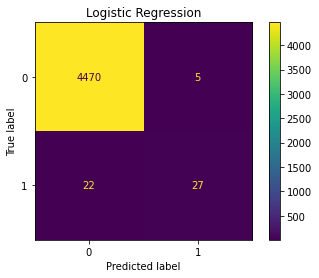

In [27]:
plot_confusion_matrix(model_log, X_val, y_val);
plt.title('Logistic Regression');
cr_log = classification_report(y_val, model_log.predict(X_val))
print(cr_log)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4475
           1       0.49      0.35      0.40        49

    accuracy                           0.99      4524
   macro avg       0.74      0.67      0.70      4524
weighted avg       0.99      0.99      0.99      4524



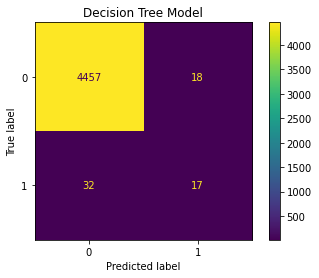

In [28]:
plot_confusion_matrix(model_dt, X_val, y_val);
plt.title('Decision Tree Model');
cr_dt = classification_report(y_val, model_dt.predict(X_val))
print(cr_dt)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4475
           1       1.00      0.10      0.19        49

    accuracy                           0.99      4524
   macro avg       1.00      0.55      0.59      4524
weighted avg       0.99      0.99      0.99      4524



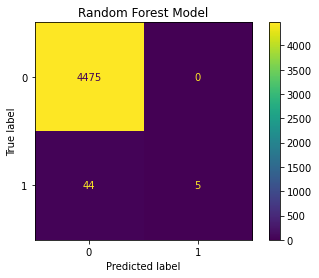

In [29]:
plot_confusion_matrix(model_rf, X_val, y_val)
plt.title('Random Forest Model');
cr_rf = classification_report(y_val, model_rf.predict(X_val))
print(cr_rf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4475
           1       0.77      0.49      0.60        49

    accuracy                           0.99      4524
   macro avg       0.88      0.74      0.80      4524
weighted avg       0.99      0.99      0.99      4524



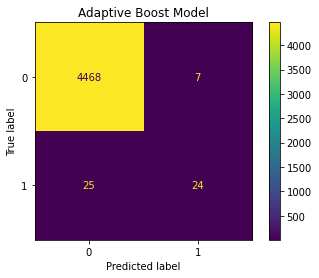

In [30]:
plot_confusion_matrix(model_ada, X_val, y_val)
plt.title('Adaptive Boost Model');
cr_ada = classification_report(y_val, model_ada.predict(X_val))
print(cr_ada)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4475
           1       0.75      0.31      0.43        49

    accuracy                           0.99      4524
   macro avg       0.87      0.65      0.72      4524
weighted avg       0.99      0.99      0.99      4524



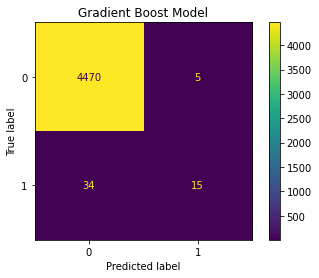

In [31]:
plot_confusion_matrix(model_gb, X_val, y_val)
plt.title('Gradient Boost Model');
cr_gb = classification_report(y_val, model_gb.predict(X_val))
print(cr_gb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4475
           1       0.93      0.27      0.41        49

    accuracy                           0.99      4524
   macro avg       0.96      0.63      0.70      4524
weighted avg       0.99      0.99      0.99      4524



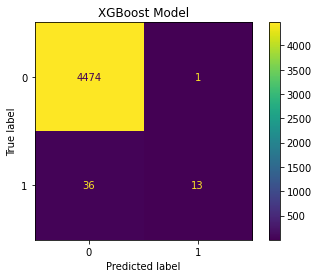

In [32]:
plot_confusion_matrix(model_xgb, X_val, y_val)
plt.title('XGBoost Model');
cr_xgb = classification_report(y_val, model_xgb.predict(X_val))
print(cr_xgb)

# Model Comparison - ROC/AUC and other metrics

In [33]:
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.wa

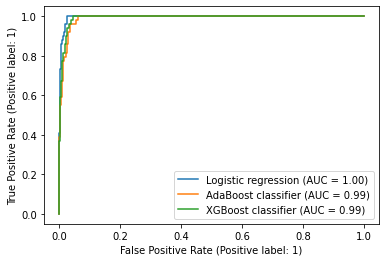

In [34]:
roc_log = plot_roc_curve(model_log,
                         X_val,
                         y_val,
                         name = 'Logistic regression')

roc_ada = plot_roc_curve(model_ada,
                         X_val,
                         y_val,
                         ax = roc_log.ax_,
                         name = 'AdaBoost classifier',
                         )

roc_xgb = plot_roc_curve(model_xgb,
                         X_val,
                         y_val,
                         ax = roc_log.ax_,
                         name = 'XGBoost classifier')

In [35]:
auc_log = roc_auc_score(y_val, model_log.predict_proba(X_val)[:,-1])
auc_ada = roc_auc_score(y_val, model_ada.predict_proba(X_val)[:,-1])
auc_xgb = roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:,-1])

print('Logistic Regression AUC:', auc_log)
print('Adaptive Boost AUC:', auc_ada)
print('XGBoost AUC:', auc_xgb)

Logistic Regression AUC: 0.9962877665032494
Adaptive Boost AUC: 0.9900581461634933
XGBoost AUC: 0.9925937749401436


In [36]:
# Found this custom function to calculate optimal threshold on StackExchange but didn't work out!

# y_proba_log = model_log.predict_proba(X_val)[:,-1]

# def Find_Optimal_Cutoff(target, predicted_proba):
#     fpr, tpr, threshold = roc_curve(target, predicted_proba)
#     i = np.arange(len(tpr)) 
#     roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
#     roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

#     return float(roc_t['threshold']) 

# optimal_threshold = Find_Optimal_Cutoff(y_val, y_proba_log)
# print(optimal_threshold)

# y_proba_log[y_proba_log >= optimal_threshold] = 1
# y_proba_log[y_proba_log < optimal_threshold] = 0

# print('Logistic Regression (w/ optimal threshold): Validation Accuracy:', accuracy_score(y_val, y_proba_log))

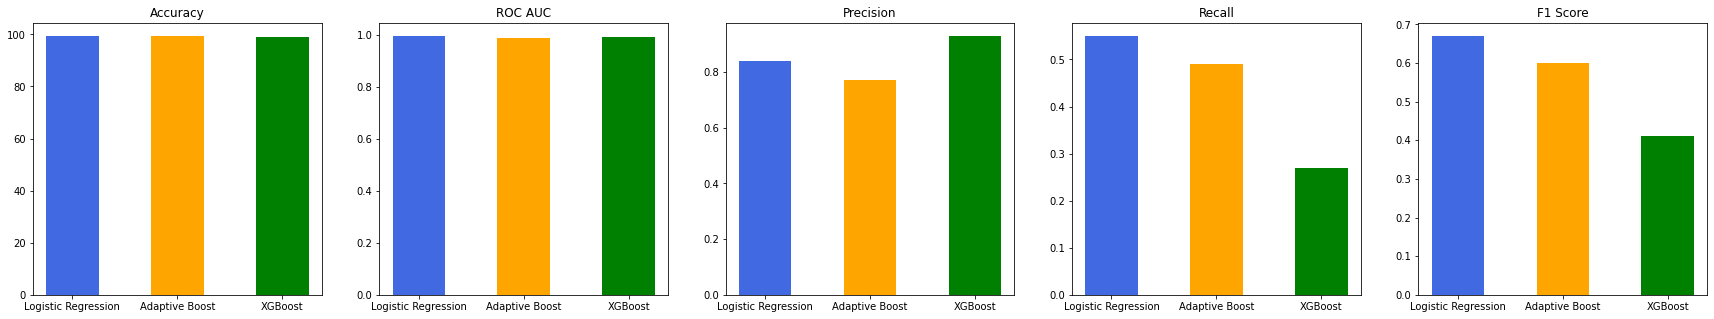

In [37]:
data_metrics = {'Accuracy': [model_log.score(X_val, y_val)*100,
                             model_ada.score(X_val, y_val)*100,
                             model_xgb.score(X_val, y_val)*100],
                'Precision': [float(cr_log[128:132]),
                              float(cr_ada[128:132]),
                              float(cr_xgb[128:132])],
                'Recall': [float(cr_log[138:142]),
                           float(cr_ada[138:142]),
                           float(cr_xgb[138:142])],
                'F1_score': [float(cr_log[148:152]),
                             float(cr_ada[148:152]),
                             float(cr_xgb[148:152])],
                'ROC_AUC': [auc_log, auc_ada, auc_xgb]
                }

df_metrics = pd.DataFrame(data_metrics, index = ['Logistic Regression', 'Adaptive Boost', 'XGBoost'])

fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize= (30,5));

ax1.bar(df_metrics.index, df_metrics['Accuracy'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax1.set_title('Accuracy')
ax2.bar(df_metrics.index, df_metrics['ROC_AUC'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax2.set_title('ROC AUC')
ax3.bar(df_metrics.index, df_metrics['Precision'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax3.set_title('Precision')
ax4.bar(df_metrics.index, df_metrics['Recall'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax4.set_title('Recall')
ax5.bar(df_metrics.index, df_metrics['F1_score'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax5.set_title('F1 Score');

# Feature Importances Plots

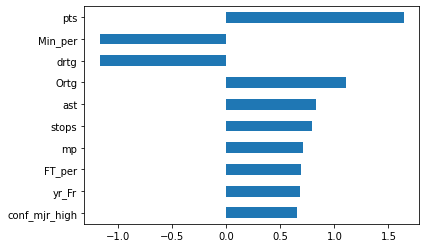

In [38]:
log_importances = model_log.named_steps['logisticregression'].coef_[0]
features = model_log['onehotencoder'].get_feature_names()
log_feat_imp = pd.Series(data=log_importances, index=features).sort_values(key=abs)
log_feat_imp.tail(10).plot(kind='barh');

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(log_feat_imp)

In [39]:
dt_importances = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
features = X_train.columns
dt_feat_imp = pd.Series(data=dt_importances, index=features).sort_values()
#dt_feat_imp.plot(kind='barh');

In [40]:
rf_importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
rf_feat_imp = pd.Series(data=rf_importances, index=features).sort_values()
#rf_feat_imp.plot(kind='barh');

In [41]:
ada_importances = model_ada.named_steps['adaboostclassifier'].feature_importances_
features = X_train.columns
ada_feat_imp = pd.Series(data=ada_importances, index=features).sort_values()
#ada_feat_imp.plot(kind='barh');

In [42]:
xgb_importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns
xgb_feat_imp = pd.Series(data=xgb_importances, index=features).sort_values()
#xgb_feat_imp.plot(kind='barh');

# Permutation Importances Plots

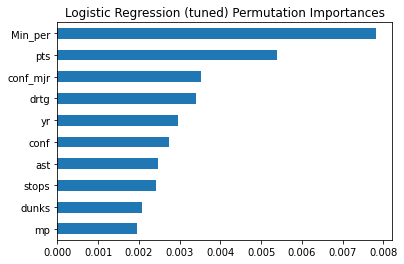

In [44]:
perm_imp = permutation_importance(model_log, X_val, y_val, random_state=42)
data_perm = {'PI_mean': perm_imp['importances_mean'],
             'PI_std': perm_imp['importances_std']
             }
df_perm = pd.DataFrame(data_perm, index = X_val.columns).sort_values(by='PI_mean', ascending=True)
df_perm['PI_mean'].tail(10).plot(kind='barh');
plt.title('Logistic Regression (tuned) Permutation Importances');

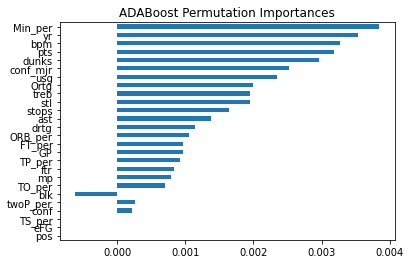

In [45]:
perm_imp = permutation_importance(model_ada, X_val, y_val, random_state=42)
data_perm = {'PI_mean': perm_imp['importances_mean'],
             'PI_std': perm_imp['importances_std']
             }
df_perm = pd.DataFrame(data_perm, index = X_val.columns).sort_values(by='PI_mean', ascending=True, key=abs)
df_perm['PI_mean'].plot(kind='barh');
plt.title('ADABoost Permutation Importances');

# Model Tuning

In [54]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [55]:
# For the Logistic Regression Model
model_log = make_pipeline(OneHotEncoder(use_cat_names = True),
                          StandardScaler(),
                          LogisticRegression(n_jobs=-1, random_state = 42)
                          )

param_grid = {'logisticregression__max_iter': [100, 200, 300],   #deafult is 100
              'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear'],  #deafult is lgfbs
              'logisticregression__penalty': ['none', 'l1', 'l2', 'elasticnet'],  #default is l2
              'logisticregression__C': [10, 1.0, 0.1]  #deafult is 1
              }

model_log_s = GridSearchCV(model_log,
                          param_grid=param_grid,
                          n_jobs=-1,
                          cv=5,
                          #n_iter=25,
                          scoring='f1',
                          verbose=1
                          )

model_log_s.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [10, 1.0, 0.1],
                         'logisticregression__max_iter': [100, 200, 300],
                         'logisticregression__penalty': ['none', 'l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear']},
             scoring='f1', verbose=1)

In [56]:
print(model_log_s.best_params_)
print('Best F1 Score:', model_log_s.best_score_)
cr_log_s = classification_report(y_val, model_log_s.predict(X_val))
print('Validation F1 Score:', cr_log_s[148:152])

{'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Best F1 Score: 0.47222388171360696
Validation F1 Score: 0.63


In [57]:
# For the XGBoost Model
model_xgb = make_pipeline(OrdinalEncoder(),
                          XGBClassifier(n_jobs=-1, random_state = 42)
                          )

param_grid = {'xgbclassifier__scale_pos_weight': [1, 10, 50, 99],  #default is 1
              'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],  #must be between 0 and 1, deafult is 0.3
              'xgbclassifier__max_depth': [3,6,9], # deafult is 6
              'xgbclassifier__n_estimators': [50,100,150] # default is 100
              }

model_xgb_s = GridSearchCV(model_xgb,
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv=5,
                           #n_iter=50
                           scoring='f1',
                           verbose=1
                           )

model_xgb_s.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('xgbclassifier',
                                        XGBClassifier(n_jobs=-1,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
                         'xgbclassifier__max_depth': [3, 6, 9],
                         'xgbclassifier__n_estimators': [50, 100, 150],
                         'xgbclassifier__scale_pos_weight': [1, 10, 50, 99]},
             scoring='f1', verbose=1)

In [58]:
print(model_xgb_s.best_params_)
print('Best F1 Score:', model_xgb_s.best_score_)
cr_xgb_s = classification_report(y_val, model_xgb_s.predict(X_val))
print('Validation F1 Score:', cr_xgb_s[148:152])

{'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__scale_pos_weight': 10}
Best F1 Score: 0.4597738511991853
Validation F1 Score: 0.61


In [59]:
# For the Adaptive Boost Model
model_ada = make_pipeline(OrdinalEncoder(),
                          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
                          )

param_grid = {'adaboostclassifier__base_estimator__max_depth': [1,2],  #default is 1
              'adaboostclassifier__learning_rate': [0.1, 0.5, 1],  #must be between 0 and 1, deafult is 1
              'adaboostclassifier__n_estimators': [50,100,150] # default is 50
              }

model_ada_s = GridSearchCV(model_ada,
                            param_grid=param_grid,
                            n_jobs=-1,
                            cv=5,
                            #n_iter=50
                            scoring='f1',
                            verbose=1,
                            )

model_ada_s.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'adaboostclassifier__base_estimator__max_depth': [1,
                                                                           2],
                         'adaboostclassifier__learning_rate': [0.1, 0.5, 1],
                         'adaboostclassifier__n_estimators': [50, 100, 150]},
             scoring='f1', verbose=1)

In [60]:
print(model_ada_s.best_params_)
print('Best F1 Score:', model_ada_s.best_score_)
cr_ada_s = classification_report(y_val, model_ada_s.predict(X_val))
print('Validation F1 Score:', cr_ada_s[148:152])

{'adaboostclassifier__base_estimator__max_depth': 1, 'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__n_estimators': 150}
Best F1 Score: 0.42280766010088044
Validation F1 Score: 0.56


# Tuned Model Comparison

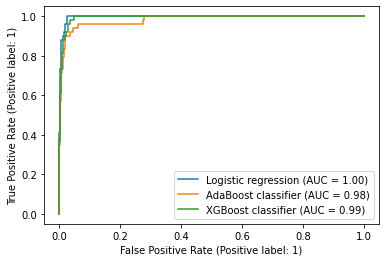

In [61]:
roc_log = plot_roc_curve(model_log_s,
                         X_val,
                         y_val,
                         name = 'Logistic regression')

roc_ada = plot_roc_curve(model_ada_s,
                         X_val,
                         y_val,
                         ax = roc_log.ax_,
                         name = 'AdaBoost classifier',
                         )

roc_xgb = plot_roc_curve(model_xgb_s,
                         X_val,
                         y_val,
                         ax = roc_log.ax_,
                         name = 'XGBoost classifier')

In [62]:
auc_log_s = roc_auc_score(y_val, model_log_s.predict_proba(X_val)[:,-1])
auc_ada_s = roc_auc_score(y_val, model_ada_s.predict_proba(X_val)[:,-1])
auc_xgb_s = roc_auc_score(y_val, model_xgb_s.predict_proba(X_val)[:,-1])

print('Logistic Regression AUC:', auc_log)
print('Adaptive Boost AUC:', auc_ada)
print('XGBoost AUC:', auc_xgb)

Logistic Regression AUC: 0.9962877665032494
Adaptive Boost AUC: 0.9900581461634933
XGBoost AUC: 0.9925937749401436


,Accuracy,ROC_AUC,Precision,Recall,F1_score
Logistic Regression,99.358974,0.996393,0.83,0.51,0.63
Adaptive Boost,99.204244,0.981694,0.70,0.47,0.56
XGBoost,99.005305,0.993492,0.53,0.71,0.61


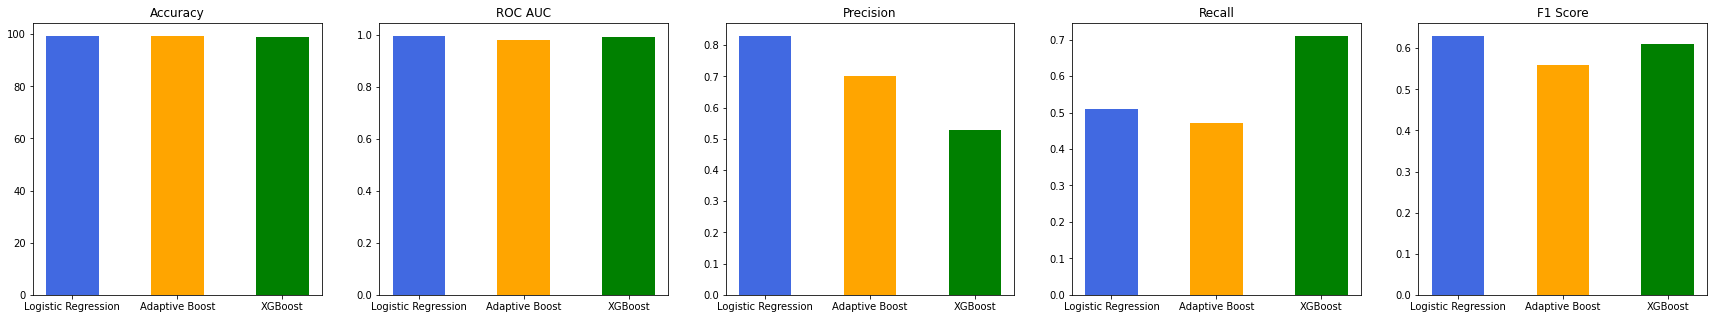

In [63]:
data_metrics = {'Accuracy': [accuracy_score(y_val, model_log_s.predict(X_val))*100,
                             accuracy_score(y_val, model_ada_s.predict(X_val))*100,
                             accuracy_score(y_val, model_xgb_s.predict(X_val))*100],
                'ROC_AUC': [auc_log_s, auc_ada_s, auc_xgb_s],
                'Precision': [float(cr_log_s[128:132]),
                              float(cr_ada_s[128:132]),
                              float(cr_xgb_s[128:132])],
                'Recall': [float(cr_log_s[138:142]),
                           float(cr_ada_s[138:142]),
                           float(cr_xgb_s[138:142])],
                'F1_score': [float(cr_log_s[148:152]),
                             float(cr_ada_s[148:152]),
                             float(cr_xgb_s[148:152])]
                }

df_metrics = pd.DataFrame(data_metrics, index = ['Logistic Regression', 'Adaptive Boost', 'XGBoost'])
display(df_metrics)

fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize= (30,5));

ax1.bar(df_metrics.index, df_metrics['Accuracy'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax1.set_title('Accuracy')
ax2.bar(df_metrics.index, df_metrics['ROC_AUC'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax2.set_title('ROC AUC')
ax3.bar(df_metrics.index, df_metrics['Precision'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax3.set_title('Precision')
ax4.bar(df_metrics.index, df_metrics['Recall'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax4.set_title('Recall')
ax5.bar(df_metrics.index, df_metrics['F1_score'], color = ['royalblue', 'orange', 'green'], width = 0.5)
ax5.set_title('F1 Score');

# Final Prediction using LR model

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4683
           1       0.70      0.14      0.24        49

    accuracy                           0.99      4732
   macro avg       0.85      0.57      0.62      4732
weighted avg       0.99      0.99      0.99      4732


Baseline accuracy: 0.9896449704142012
Model accuracy: 0.9904902789518174
F1 Score: 0.23728813559322035





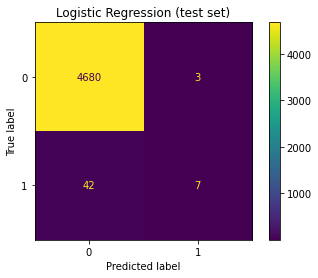

In [64]:
# Testing set using LR (my original chosen model)

y_pred = model_log_s.predict(X_test)
cr_test = classification_report(y_test, y_pred)
print(cr_test)
plot_confusion_matrix(model_log_s, X_test, y_test)
plt.title('Logistic Regression (test set)')

#print('Test accuracy:', accuracy_score(y_test, y_pred))
#print('Test precision:', float(cr_test[128:132]))
#print('Test recall:', float(cr_test[138:142]))
#print('Test F1 Score:', float(cr_test[148:152]))

print('Baseline accuracy:', y_test.value_counts(normalize=True).max())
print('Model accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', model_log_s.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4683
           1       0.49      0.49      0.49        49

    accuracy                           0.99      4732
   macro avg       0.74      0.74      0.74      4732
weighted avg       0.99      0.99      0.99      4732


Baseline accuracy: 0.9896449704142012
Model accuracy: 0.9894336432797971
F1 Score: 0.4897959183673469





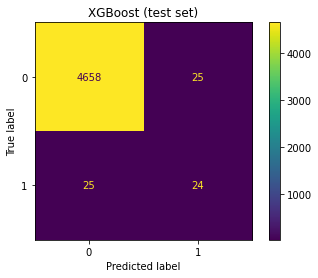

In [65]:
# Testing set using XGBoost

y_pred = model_xgb_s.predict(X_test)
cr_test = classification_report(y_test, y_pred)
print(cr_test)
plot_confusion_matrix(model_xgb_s, X_test, y_test)
plt.title('XGBoost (test set)')

#print('Test accuracy:', accuracy_score(y_test, y_pred))
#print('Test precision:', float(cr_test[128:132]))
#print('Test recall:', float(cr_test[138:142]))
#print('Test F1 Score:', float(cr_test[148:152]))

print('Baseline accuracy:', y_test.value_counts(normalize=True).max())
print('Model accuracy:', accuracy_score(y_test, y_pred))

# SMOTE Oversampling Technique

In [ ]:
from imblearn.over_sampling import SMOTENC

In [ ]:
smotenc = SMOTENC([0,13,24,25], random_state = 42)
X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)
print(X_oversample.shape, y_oversample.shape)

In [ ]:
# Baseline Accuracy
print(y_oversample.value_counts())
print(y_val.value_counts())

baseline_train_acc = y_oversample.value_counts(normalize=True).max()*100
baseline_val_acc = y_val.value_counts(normalize=True).max()*100

print('The baseline training accuracy is:', baseline_train_acc)
print('The baseline validation accuracy is:', baseline_val_acc)


In [ ]:
model_logSM = make_pipeline(OneHotEncoder(use_cat_names = True),
                          StandardScaler(),
                          LogisticRegression(n_jobs=-1, random_state=42)
                          )
model_logSM.fit(X_oversample, y_oversample)

In [ ]:
print('Logistic Regression: Training Accuracy:', model_logSM.score(X_train, y_train)*100)
print('Logistic Regression: Validation Accuracy:', model_logSM.score(X_val, y_val)*100)

In [ ]:
plot_confusion_matrix(model_logSM, X_val, y_val);
plt.title('Logistic Regression SM Model');
cr_log = classification_report(y_val, model_logSM.predict(X_val))
print(cr_log)

SMOTE oversampling improved my validation recall to almost a perfect score but reduced the precision of the logsitic regression model by quite a bit - there are now many more false positives. Overall, oversampling in this instance actually reduced the F1 score